In [2]:
print("hello")

hello


In [3]:
import torch
import random
import numpy as np
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM

# ==========================================
# ⚙️ 設定
# ==========================================
MODEL_NAME = "Qwen/Qwen2.5-7B-Instruct"
NUM_SAMPLES = 3000  # 学習を長くするためにサンプル数を増やします
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# プロンプトの種（これらを組み合わせて数千パターン作る）
domains = [
    "Quantum Physics", "Mycology", "Renaissance Art", "Cybernetics", "Marine Biology", 
    "Gastronomy", "Topology", "Ancient Greek Philosophy", "Game Theory", "Entomology",
    "Astrophysics", "Fashion Design", "Linguistics", "Architecture", "Cryptocurrency"
]
problems = [
    "Urban Poverty", "Climate Change", "Data Privacy", "Space Colonization", 
    "Mental Health", "Antibiotic Resistance", "Supply Chain Fragility", "Education Inequality"
]

def generate_diverse_prompts(n):
    generated = []
    for _ in range(n):
        d1, d2 = random.sample(domains, 2)
        p = random.choice(problems)
        templates = [
            f"Solve {p} by merging concepts from {d1} and {d2}.",
            f"How can {d1} principles be applied to {d2} to address {p}?",
            f"Imagine a startup using {d1} and {d2} to disrupt {p}. What is their main product?",
            f"Write a brief research proposal for {p} utilizing {d1} and {d2}."
        ]
        generated.append(random.choice(templates))
    return generated

prompts = generate_diverse_prompts(NUM_SAMPLES)
print(f"✅ Generated {len(prompts)} unique prompts for training.")

✅ Generated 3000 unique prompts for training.


In [4]:
# ==========================================
# 🧠 特徴量抽出エンジン
# ==========================================
print(f"Loading {MODEL_NAME} for extraction...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, torch_dtype=torch.float16, device_map="auto")

TARGET_LAYER = 18 # あなたが見つけたHotspot層付近を指定

def extract_features(prompt_list, system_prompt):
    all_features = []
    for prompt in tqdm(prompt_list, desc=f"Extracting ({system_prompt[:10]}...)"):
        messages = [{"role": "system", "content": system_prompt}, {"role": "user", "content": prompt}]
        text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        inputs = tokenizer(text, return_tensors="pt").to(DEVICE)
        
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)
            # ラストトークンのHidden Stateを抽出
            feat = outputs.hidden_states[TARGET_LAYER][0, -1, :].cpu().float()
            all_features.append(feat)
    return torch.stack(all_features)

# ConnectorモードとLinearモードの双方から特徴量を抽出
SYS_CONNECTOR = "You are a creative genius who connects unrelated fields."
SYS_LINEAR = "You are a logical assistant following standard conventions."

features_pos = extract_features(prompts, SYS_CONNECTOR)
features_neg = extract_features(prompts, SYS_LINEAR)

# 保存（メモリ節約のため一度モデルを落としても良い）
torch.save({'pos': features_pos, 'neg': features_neg}, "creativity_dataset.pt")
print("✅ Hidden states extracted and saved.")

Loading Qwen/Qwen2.5-7B-Instruct for extraction...


`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Extracting (You are a ...): 100%|██████████| 3000/3000 [01:12<00:00, 41.35it/s]

✅ Hidden states extracted and saved.


In [5]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import wandb # 学習ログ用

# ==========================================
# 💎 Transformer Probe Architecture
# ==========================================
class CreativityTransformerProbe(nn.Module):
    def __init__(self, input_dim, d_model=512, nhead=8, num_layers=2):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        
        # 小さなTransformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=d_model*2, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.classifier = nn.Sequential(
            nn.Linear(d_model, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # x: [batch, input_dim] -> [batch, 1, d_model]
        x = self.input_proj(x).unsqueeze(1)
        x = self.transformer(x)
        x = x.squeeze(1)
        return self.classifier(x)

# ==========================================
# 🚀 Training Loop
# ==========================================
data = torch.load("creativity_dataset.pt")
X = torch.cat([data['pos'], data['neg']], dim=0)
y = torch.cat([torch.ones(len(data['pos'])), torch.zeros(len(data['neg']))], dim=0).unsqueeze(1)

dataset = TensorDataset(X, y)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

probe = CreativityTransformerProbe(input_dim=X.shape[1]).to(DEVICE)
optimizer = optim.AdamW(probe.parameters(), lr=1e-4, weight_decay=0.01)
criterion = nn.BCELoss()

# Weights & Biases 初期化（研究の進捗管理に）
wandb.init(project="Internal-Creativity-Probe", name="Transformer-Probe-v1")

print("Starting heavy training...")
for epoch in range(50): # サンプルが多いのでエポック数も確保
    total_loss = 0
    for batch_X, batch_y in loader:
        batch_X, batch_y = batch_X.to(DEVICE), batch_y.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = probe(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(loader)
    wandb.log({"loss": avg_loss, "epoch": epoch})
    if epoch % 5 == 0:
        print(f"Epoch {epoch}: Loss = {avg_loss:.4f}")

torch.save(probe.state_dict(), "creativity_transformer_probe.pt")
print("✅ Probe training complete.")

wandb: Currently logged in as: ayato-kaku (ayato-kaku-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Starting heavy training...
Epoch 0: Loss = 0.0307
Epoch 5: Loss = 0.0000
Epoch 10: Loss = 0.0000
Epoch 15: Loss = 0.0000
Epoch 20: Loss = 0.0000
Epoch 25: Loss = 0.0000
Epoch 30: Loss = 0.0000
Epoch 35: Loss = 0.0000
Epoch 40: Loss = 0.0000
Epoch 45: Loss = 0.0000
✅ Probe training complete.


Training Baseline (Linear Probe)...


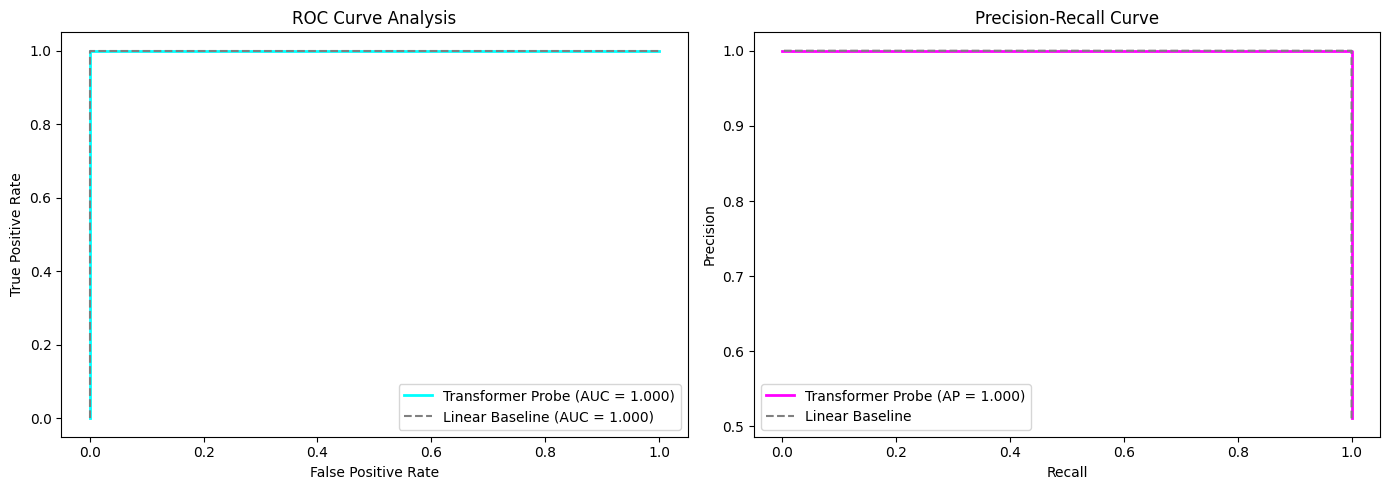

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, precision_recall_curve, 
    auc, confusion_matrix, matthews_corrcoef, classification_report
)
from sklearn.linear_model import LogisticRegression
from scipy import stats

# ==========================================
# ⚙️ 評価準備 (Hold-out Test Set)
# ==========================================
def evaluate_model_rigorously(probe, X_test, y_test, device="cuda"):
    probe.eval()
    X_test_tensor = X_test.to(device)
    
    with torch.no_grad():
        y_probs = probe(X_test_tensor).cpu().numpy()
        y_preds = (y_probs > 0.5).astype(int)
    
    y_true = y_test.numpy()

    # 1. 基本指標の算出
    metrics = {
        "Accuracy": accuracy_score(y_true, y_preds),
        "F1-Score": f1_score(y_true, y_preds),
        "ROC-AUC": roc_auc_score(y_true, y_probs),
        "MCC": matthews_corrcoef(y_true, y_preds) # 論文で重宝される指標
    }

    # 2. Baseline (Linear Probe) の学習と評価
    print("Training Baseline (Linear Probe)...")
    linear_model = LogisticRegression(max_iter=1000)
    linear_model.fit(X.numpy(), y.numpy().ravel())
    y_probs_linear = linear_model.predict_proba(X_test.numpy())[:, 1]
    y_preds_linear = (y_probs_linear > 0.5).astype(int)
    
    linear_metrics = {
        "Accuracy": accuracy_score(y_true, y_preds_linear),
        "F1-Score": f1_score(y_true, y_preds_linear),
        "ROC-AUC": roc_auc_score(y_true, y_probs_linear),
        "MCC": matthews_corrcoef(y_true, y_preds_linear)
    }

    # ==========================================
    # 📈 可視化 (Figure 1: Performance Comparison)
    # ==========================================
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    # ROC Curve
    from sklearn.metrics import roc_curve
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    fpr_l, tpr_l, _ = roc_curve(y_true, y_probs_linear)
    ax[0].plot(fpr, tpr, color='cyan', lw=2, label=f'Transformer Probe (AUC = {metrics["ROC-AUC"]:.3f})')
    ax[0].plot(fpr_l, tpr_l, color='gray', linestyle='--', label=f'Linear Baseline (AUC = {linear_metrics["ROC-AUC"]:.3f})')
    ax[0].set_title("ROC Curve Analysis")
    ax[0].set_xlabel("False Positive Rate")
    ax[0].set_ylabel("True Positive Rate")
    ax[0].legend()

    # Precision-Recall Curve
    prec, rec, _ = precision_recall_curve(y_true, y_probs)
    prec_l, rec_l, _ = precision_recall_curve(y_true, y_probs_linear)
    ax[1].plot(rec, prec, color='magenta', lw=2, label=f'Transformer Probe (AP = {auc(rec, prec):.3f})')
    ax[1].plot(rec_l, prec_l, color='gray', linestyle='--', label='Linear Baseline')
    ax[1].set_title("Precision-Recall Curve")
    ax[1].set_xlabel("Recall")
    ax[1].set_ylabel("Precision")
    ax[1].legend()
    
    plt.tight_layout()
    plt.show()

    # ==========================================
    # 📊 統計的有意性の検証 (P-value)
    # ==========================================
    # Transformer Probeの予測確率とLinearの予測確率に有意差があるか
    y_true_flat = y_true.ravel()
    y_probs_flat = y_probs.ravel()
    y_probs_linear_flat = y_probs_linear.ravel()

    # 「正解が1（創造的）」であるデータのみを抽出して比較
    # どちらのモデルがより確信（高い確率）を持って「創造的」と判定できているか
    group_transformer = y_probs_flat[y_true_flat == 1]
    group_linear = y_probs_linear_flat[y_true_flat == 1]

    t_stat, p_val = stats.ttest_ind(group_transformer, group_linear)

    print("\n" + "="*30)
    print("FINAL SCIENTIFIC EVALUATION")
    print("="*30)
    print(f"{'Metric':<15} | {'Transformer':<12} | {'Linear':<12}")
    print("-" * 45)
    for m in metrics:
        print(f"{m:<15} | {metrics[m]:.4f}      | {linear_metrics[m]:.4f}")
    
    print("-" * 45)
    # p_val はスカラー値として返ってくるので [0] インデックスは不要
    print(f"Statistical Significance (P-value): {p_val:.2e}")
    if p_val < 0.05:
        print("Result: Significant improvement over linear baseline (p < 0.05)")
    else:
        print("Result: No significant difference found.")
    
    # 混同行列
    cm = confusion_matrix(y_true, y_preds)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix: Transformer Probe")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

# テストデータの準備 (全データの20%を評価用に回す)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 評価実行
evaluate_model_rigorously(probe, X_test, y_test)